#**MACHINE LEARNING PROJECT: Creating Regression and Clustering Models**

#EDA

In [1]:
!pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, silhouette_samples, silhouette_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_transaction = pd.read_csv('/content/drive/MyDrive/Rakamin/Kalbe VIX-DS/Case Study - Transaction.csv',sep = ';')
df_cust = pd.read_csv('/content/drive/MyDrive/Rakamin/Kalbe VIX-DS/Case Study - Customer.csv',sep = ';')
df_store = pd.read_csv('/content/drive/MyDrive/Rakamin/Kalbe VIX-DS/Case Study - Store.csv',sep = ';')
df_product = pd.read_csv('/content/drive/MyDrive/Rakamin/Kalbe VIX-DS/Case Study - Product.csv',sep = ';')

In [4]:
df_transaction.head(2)

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1


In [5]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


In [6]:
df_transaction.duplicated().sum()

0

In [7]:
df_cust.head(2)

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"


In [8]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


In [9]:
df_cust.duplicated().sum()

0

In [10]:
df_store.head(2)

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"


In [11]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 800.0+ bytes


In [12]:
df_store.duplicated().sum()

0

In [13]:
df_product.head(2)

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200


In [14]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


In [15]:
df_product.duplicated().sum()

0

#Data Preprocessing

In [16]:
# Replace commas
def convert_income(income):
    if ',' in income:
        income = income.replace(',', '')
        return float(income) * 10000
    else:
        return float(income) * 1000000

df_cust['Income'] = df_cust['Income'].apply(convert_income)
df_store['Latitude'] = df_store['Latitude'].str.replace(',', '.')
df_store['Longitude'] = df_store['Longitude'].str.replace(',', '.')

#Change Data Type
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'], format='%d/%m/%Y')
df_cust['Income'] = df_cust['Income'].astype(int)
df_store['Latitude'] = df_store['Latitude'].astype(float)
df_store['Longitude'] = df_store['Longitude'].astype(float)

In [17]:
df_store.head(2)

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666
1,2,Prima Kelapa Dua,Prima,Modern Trade,-6.914864,107.608238


In [18]:
df_cust.head(2)

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,5120000
1,2,60,1,Married,6230000


In [19]:
df_cust.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

In [20]:
# Handling Missing Value
df_cust = df_cust.fillna(df_cust.mode().iloc[0])
df_cust.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    0
Income            0
dtype: int64

In [21]:
#Merge Data
df_merge = pd.merge(df_transaction,df_product.drop(columns=['Price']), on='ProductID')
df_merge = pd.merge(df_merge,df_cust,on='CustomerID')
df_merge = pd.merge(df_merge,df_store,on='StoreID')
df_merge.head(2)

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Product Name,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,Crackers,36,0,Married,10530000,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR52573,421,2022-05-05,P7,9400,3,28200,12,Coffee Candy,35,0,Married,9010000,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [22]:
df_merge.shape

(5020, 18)

# Modeling Data

## Regression Time Series (Arima)

In [23]:
# Create df for regression
df_agg = df_merge.groupby(['Date'])['Qty'].sum().reset_index()
df_agg.sort_values(by='Date', inplace=True)
df_agg.set_index('Date', inplace=True)
df_agg

,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,45
2022-01-05,30
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


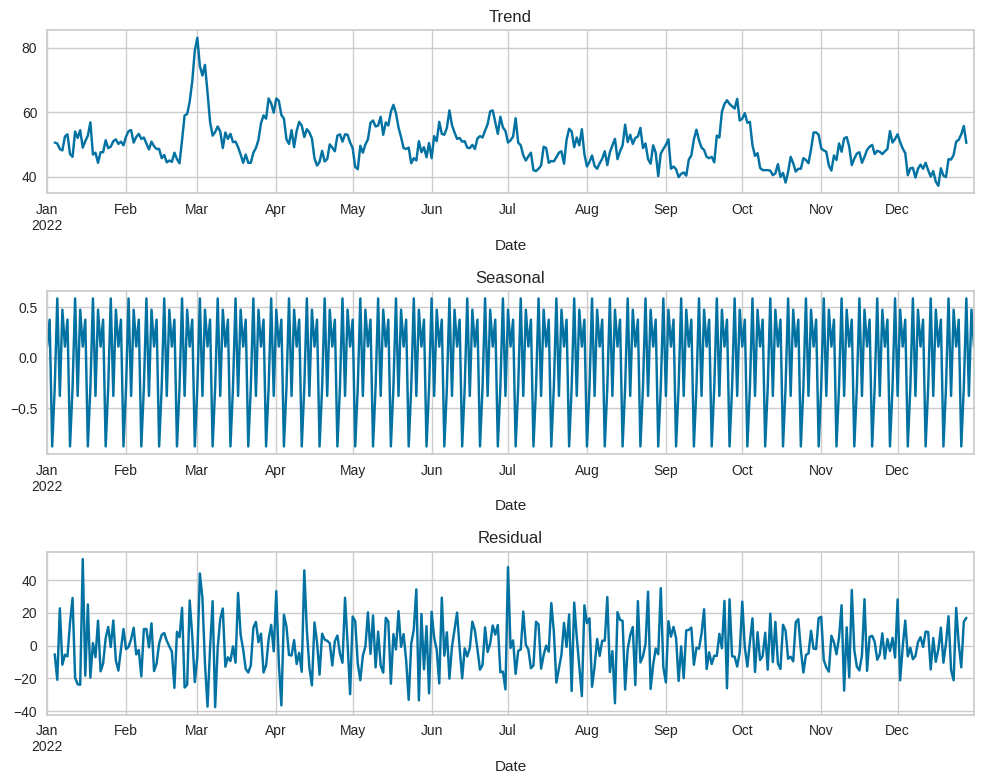

In [24]:
sd = seasonal_decompose(df_agg)
plt.figure(figsize=(10,8))

plt.subplot(311)
sd.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
sd.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.subplot(313)
sd.resid.plot(ax=plt.gca())
plt.title('Residual')

plt.tight_layout()
plt.show()

In [25]:
#Stationary Test
result_adf = adfuller(df_agg)
statistic = result_adf[0]
pvalue = result_adf[1]
cv = result_adf[4]
print('ADF Statistic:', statistic)
print('p-value:', pvalue)
print('Critical Values:', cv)
if pvalue <= 0.05:
    print('The data time series is stationary (reject 0 hypothesis)')
else:
    print('The data time series is not stationary (accepted 0 hypothesis)')

ADF Statistic: -19.448086319449082
p-value: 0.0
Critical Values: {'1%': -3.4484434475193777, '5%': -2.869513170510808, '10%': -2.571017574266393}
The data time series is stationary (reject 0 hypothesis)


In [26]:
# Split Data Train:Test = 80:20
train_data, test_data = train_test_split(df_agg, test_size=0.2, shuffle=False)
train_data

,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,45
2022-01-05,30
...,...
2022-10-15,33
2022-10-16,26
2022-10-17,53


In [27]:
test_data

,Qty
Date,
2022-10-20,39
2022-10-21,35
2022-10-22,56
2022-10-23,59
2022-10-24,39
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


In [28]:
# Search for pdq
auto_arima = auto_arima(train_data['Qty'], start_p=1, start_d=1, start_q=1,
                   max_p=3, max_d=3, max_q=3, seasonal=False,
                   stepwise=False, trace=True, suppress_warnings=True)
auto_arima.summary()

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3158.558, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2971.825, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2858.751, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2818.103, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2688.721, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2504.937, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2506.794, Time=0.21 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2508.733, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2616.108, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2506.798, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2591.264, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2508.739, Time=0.33 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec

Best model:  ARIMA(1,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1249.469
Date:                Thu, 26 Oct 2023   AIC                           2504.937
Time:                        19:06:35   BIC                           2515.968
Sample:                    01-01-2022   HQIC                          2509.356
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   3.08e-05   3.25e+04      0.000       1.000       1.000
ma.L1         -0.9898      0.015    -66.556      0.000      -1.019      -0.961
sigma2       298.6887     22.254     13.422      0.000     255.072     342.306
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                18.30
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.53
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# Arima Model
p, d, q = auto_arima.order
model = sm.tsa.ARIMA(train_data['Qty'], order=(p, d, q))
model_fit = model.fit()

In [30]:
# Forecast for Next 60 Days
start_date = '2023-01-01'
forecast_periods = 60
date_range = pd.date_range(start=start_date, periods=forecast_periods)

prediction = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

forecast = model_fit.forecast(steps=forecast_periods)
df_forecast = pd.DataFrame(forecast, index=date_range, columns=['Qty'])

In [31]:
prediction.mean()

51.033851537585065

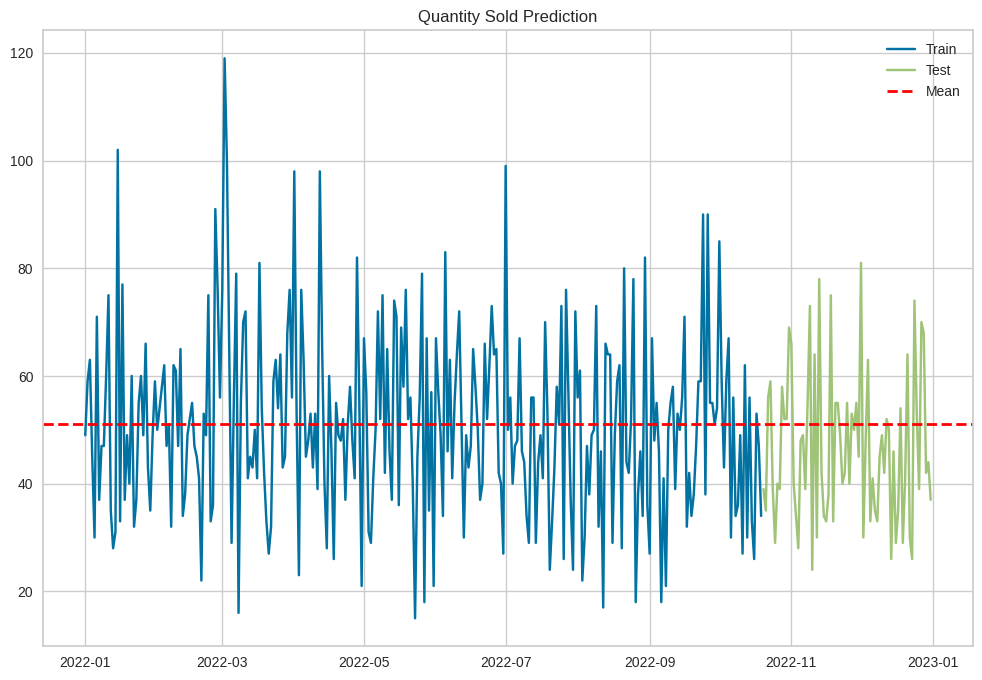

In [32]:
plt.figure(figsize=(12,8))
plt.title('Quantity Sold Prediction')
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.axhline(prediction.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.legend(loc='best')
plt.show()

In [33]:
# Forecast Product Qty for Next 60days
list_pr = df_merge['Product Name'].unique()

df_pr = pd.DataFrame({'Date':pd.date_range(start='2023-01-01',periods=60)})
df_pr = df_pr.set_index('Date')
for i in list_pr:
    df_1 = df_merge[['Qty', 'Date', 'Product Name']]
    df_1 = df_1[df_1['Product Name']==i]
    df_1= df_1.groupby('Date')[['Qty']].sum()
    df_1 = df_1.reset_index()

    df_2 = pd.DataFrame({'Date':pd.date_range(start='2022-01-01',periods=60)})
    df_2 = df_2.merge(df_1,how='left',on='Date')
    df_2 = df_2.fillna(0)
    df_2 = df_2.set_index('Date')

    model1 = ARIMA(df_2, order=(p,d,q))
    model_fit1 = model1.fit()
    forecast1 = model_fit1.forecast(steps=60)
    df_pr[i] = forecast1.values

df_pr.head()

,Crackers,Coffee Candy,Cashew,Choco Bar,Potato Chip,Thai Tea,Oat,Cheese Stick,Yoghurt,Ginger Candy
Date,,,,,,,,,,
2023-01-01,5.496187,3.718259,2.206769,5.369619,3.243793,7.563835,3.609828,3.189430,4.829483,11.663756
2023-01-02,5.364506,3.938824,2.112403,7.103949,2.718305,8.905672,2.841501,3.763366,5.017659,5.800002
2023-01-03,5.452989,4.129009,2.056786,6.994985,2.995922,8.484750,3.366095,3.853104,4.924354,9.364262
2023-01-04,5.393533,4.292999,2.024007,7.001831,2.849256,8.616789,3.007916,3.867134,4.970618,7.197740
2023-01-05,5.433485,4.434402,2.004688,7.001401,2.926740,8.575370,3.252472,3.869328,4.947679,8.514652


In [34]:
df_pr.describe().T['mean']

Crackers         5.418213
Coffee Candy     5.125882
Cashew           1.986287
Choco Bar        6.975838
Potato Chip      2.903705
Thai Tea         8.572302
Oat              3.157767
Cheese Stick     3.856295
Yoghurt          4.953881
Ginger Candy     8.054598
Name: mean, dtype: float64

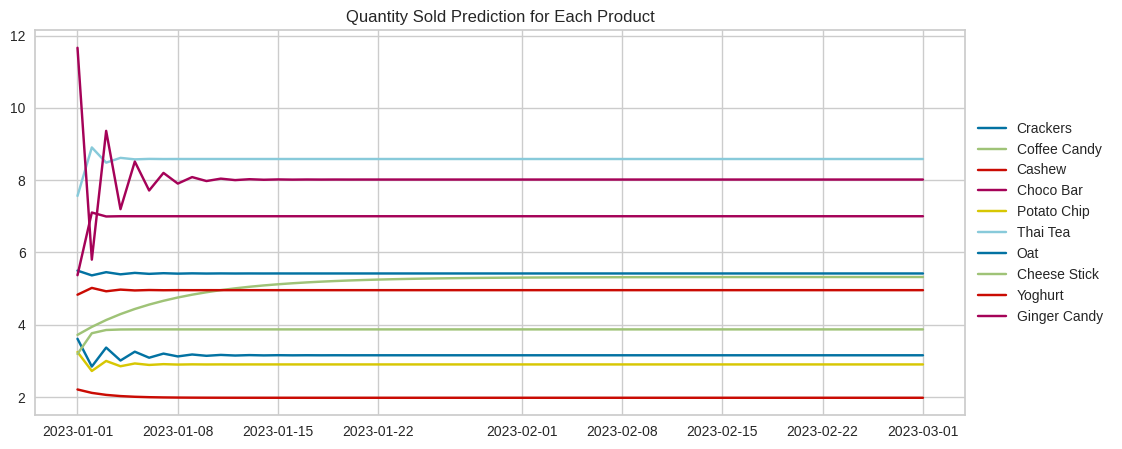

In [35]:
plt.figure(figsize=(12,5))
plt.plot(df_pr)
plt.legend(df_pr.columns,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Quantity Sold Prediction for Each Product')
plt.show()

In [36]:
import math
from sklearn.metrics import mean_squared_error

def calculate_rmse(y_actual, y_pred):
    mse = mean_squared_error(y_actual, y_pred)
    rmse = math.sqrt(mse)
    return rmse

def calculate_mae(y_actual, y_pred):
    absolute_errors = abs(y_actual - y_pred)
    mae = absolute_errors.mean()
    return mae

rmse = calculate_rmse(test_data['Qty'], prediction[:len(test_data)])
mae = calculate_mae(test_data['Qty'], prediction[:len(test_data)])

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 14.50728284249015
MAE: 12.219789018845061


##Elbow Method K-Means Clustering

In [37]:
df_clus = df_merge.groupby(['CustomerID']).agg({'TransactionID':'count','Qty':'sum','TotalAmount':'sum','Age':'first'}).reset_index().rename(columns={'TransactionID':'Num_of_Transaction','Qty':'Total_Qty'})
df_clus.head(2)

,CustomerID,Num_of_Transaction,Total_Qty,TotalAmount,Age
0,1,17,60,623300,55
1,2,13,57,392300,60


In [38]:
# Standardization
features = ['Num_of_Transaction','Total_Qty','TotalAmount','Age']
scaler = StandardScaler()
df_std = scaler.fit_transform(df_clus[features])
df_std = pd.DataFrame(data=df_std, columns=features)
df_std.head(2)

,Num_of_Transaction,Total_Qty,TotalAmount,Age
0,1.779816,1.496527,2.094768,1.185648
1,0.545884,1.261093,0.239269,1.575227


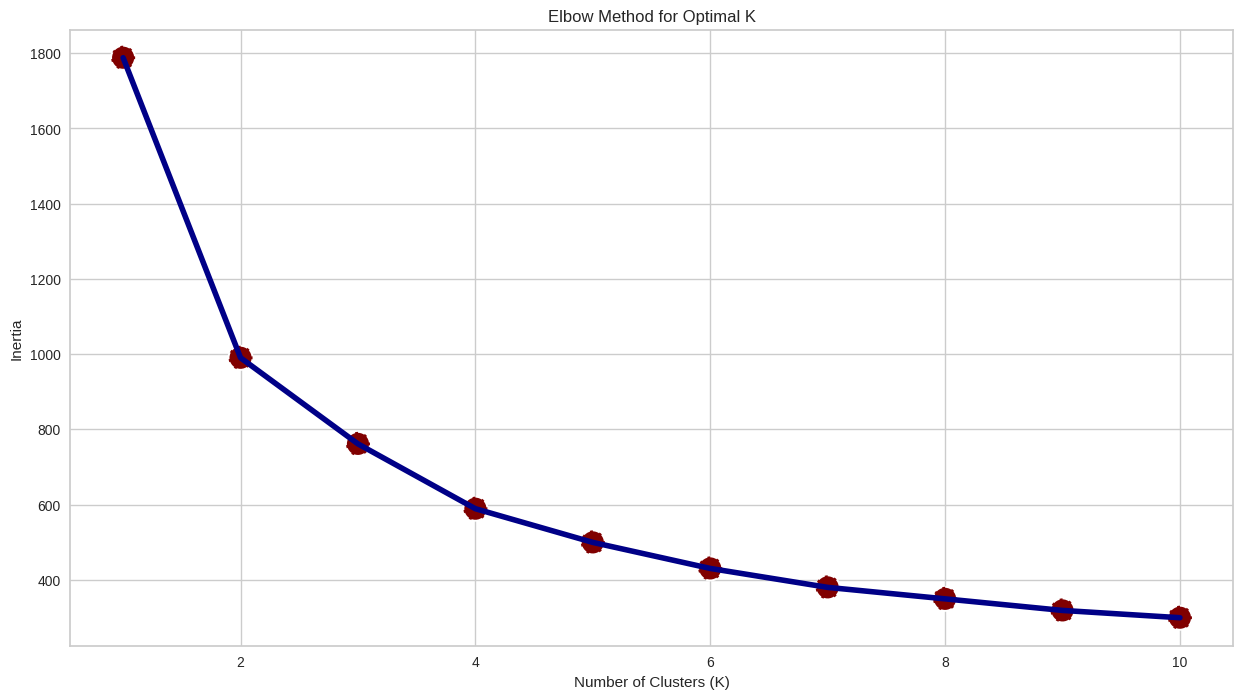

In [39]:
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_std.values)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(15, 8))
sns.lineplot(x=K, y=inertia, color='#000087', linewidth=4)
sns.scatterplot(x=K, y=inertia, s=300, color='#800000', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

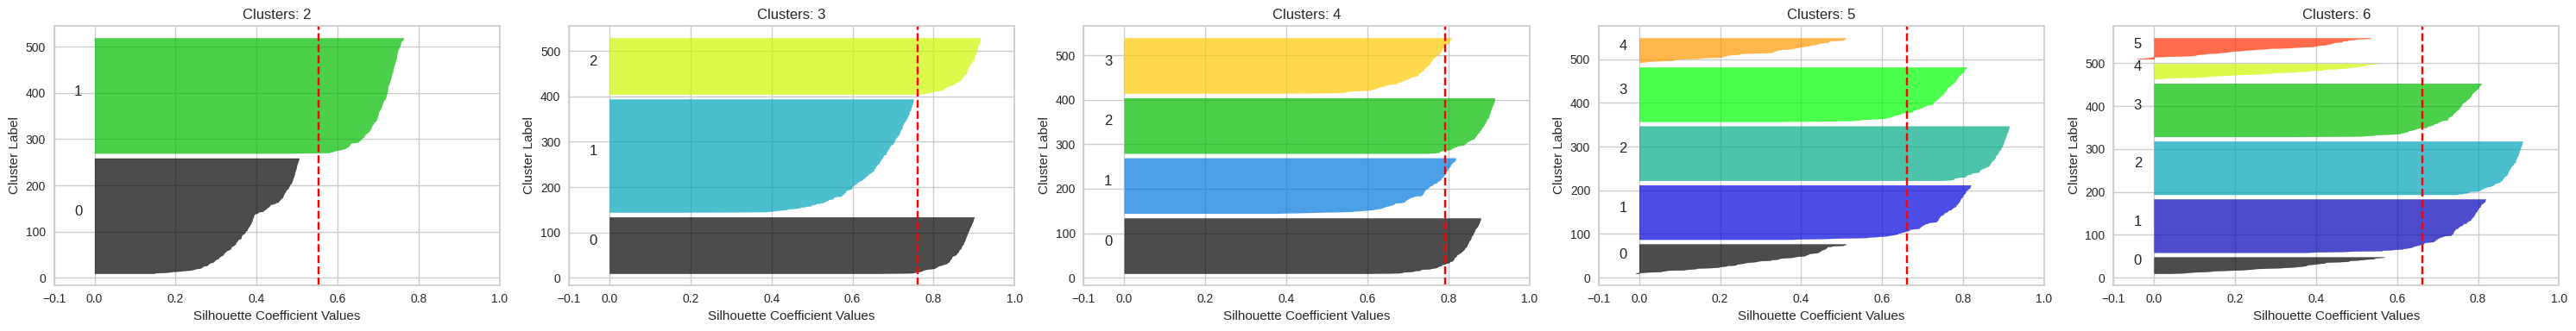

   n_clusters  silhouette_score
0           2          0.553480
1           3          0.761348
2           4          0.791104
3           5          0.661600
4           6          0.661539


In [40]:
def visualize_silhouette(data, range_n_clusters):
    fig, axes = plt.subplots(1, len(range_n_clusters), figsize=(len(range_n_clusters) * 6, 4))
    results = []

    for i, n_clusters in enumerate(range_n_clusters):
        cluster_labels = KMeans(n_clusters=n_clusters, n_init="auto", random_state=42).fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([n_clusters, silhouette_avg])

        y_lower = 10
        for j in range(n_clusters):
            ith_cluster_silhouette_values = silhouette_samples(data, cluster_labels)[cluster_labels == j]
            ith_cluster_silhouette_values.sort()
            size_cluster_j = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_j
            color = cm.nipy_spectral(float(j) / n_clusters)
            axes[i].fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )
            axes[i].text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
            y_lower = y_upper + 10

        axes[i].set_title("Clusters: {}".format(n_clusters))
        axes[i].set_xlabel("Silhouette Coefficient Values")
        axes[i].set_ylabel("Cluster Label")
        axes[i].axvline(x=silhouette_avg, color="red", linestyle="--")
        axes[i].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])

# Generate sample data
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=42,
)

# Define range of clusters
range_n_clusters = [2, 3, 4, 5, 6]

# Visualize silhouette analysis
results_df = visualize_silhouette(X, range_n_clusters)
print(results_df)

Based on the comparison graph, Elbow Method and Silhouette analysis for KMeans clustering is chosen cluster 4 with a silhouette score of 0.791104.

In [41]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_std.values)
df_std['cluster'] = kmeans.labels_
df_std.head(2)

,Num_of_Transaction,Total_Qty,TotalAmount,Age,cluster
0,1.779816,1.496527,2.094768,1.185648,1
1,0.545884,1.261093,0.239269,1.575227,2


In [42]:
#PCA visualisation
pca = PCA(n_components=2).fit(df_std)
pcs = pca.transform(df_std)

df_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
df_pca['cluster'] = df_std['cluster']
df_pca.sample(5)

,PC 1,PC 2,cluster
55,-2.725994,-0.353635,0
243,0.076289,1.833182,3
425,-2.329477,-0.397566,0
442,2.003432,-0.841333,1
53,0.720077,1.010278,3


Text(0.5, 1.0, 'PCA KDE')

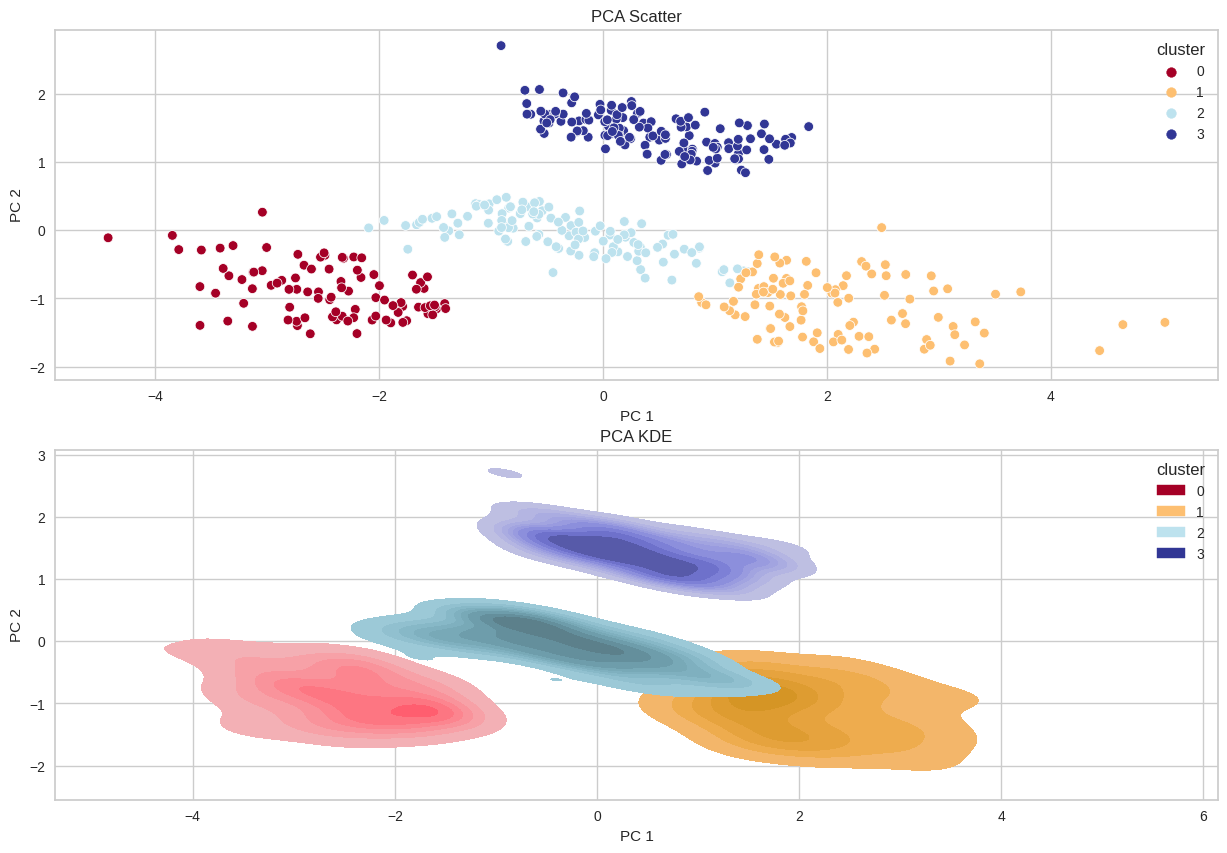

In [43]:
fig,ax = plt.subplots(2,1,figsize=(15,10))
sns.scatterplot(data=df_pca, x='PC 1', y='PC 2', hue='cluster', palette='RdYlBu',ax=ax[0])
ax[0].set_title('PCA Scatter')
sns.kdeplot(data=df_pca,x='PC 1', y='PC 2',hue='cluster',palette='RdYlBu',fill=True,ax=ax[1])
ax[1].set_title('PCA KDE')

#Interpreting Data

In [44]:
df_clus['cluster'] = kmeans.labels_
df_stat = display(df_clus.groupby('cluster').agg({'CustomerID':'count','Num_of_Transaction':'mean','Total_Qty':'mean','TotalAmount':'mean','Age':'mean'}))

,CustomerID,Num_of_Transaction,Total_Qty,TotalAmount,Age
cluster,,,,,
0,92,7.141304,25.336957,212602.173913,35.076087
1,100,15.540000,58.020000,533067.000000,40.620000
2,117,10.606838,36.863248,325430.769231,53.256410
3,138,11.362319,42.391304,370300.724638,30.891304


**Interpreting**
1. **Cluster 0**:
  - Customers in this cluster have low transaction frequency and spending. They make small purchases and have a limited number of transactions.
  - Recommendation: Offering loyalty programs or special discounts to increase purchase frequency.
2. **Cluster 1**:
  - Customers in this cluster are highly active. They make a large number of transactions, buy in bulk, and have high spending.
  - Recommendation: Providing excellent customer service and offering incentives to loyal customers to further increase their spending.
3. **Cluster 2**:
  - Customers in this cluster are middle-range customers with moderately stable transaction levels and spending. They are not as active as Cluster 1 but have higher spending than Cluster 0.
  - Recommendation: Increasing the spending of customers through targeted promotions or discounts on specific products or categories. Providing more personalized and tailored customer service to enhance customer satisfaction.
4. **Cluster 3**:
  - Customers in this cluster have relatively stable transaction frequency and spending. Although they have high spending, they are not as active as Cluster 1.
  - Recommendation: Ensuring customers remain engaged and satisfied with the services and products offered. Conduct customer satisfaction surveys to understand if there are areas that need improvement or enhancement in customer service or experience.
